In [1]:
import numpy as np
import scipy.signal
from matplotlib.pyplot import *
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
from filter_function import *
from spectrogram import *
from wav_preprocessing import *
import matplotlib.image as mpimg
import glob
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, UpSampling2D, Input,Dropout,Conv2DTranspose,Concatenate
from keras.layers import  Conv1D, MaxPooling1D, UpSampling1D,Concatenate, PReLU
from keras import optimizers

Using TensorFlow backend.


In [2]:
original_dataset_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\recordings\\"

base_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\super_resolution_re_im"
train_dir = os.path.join(base_dir, 'train\\')

test_dir = os.path.join(base_dir, 'test\\')
train_dir_filtré=os.path.join(base_dir, 'train_dir_filtré\\')
test_dir_filtré=os.path.join(base_dir, 'test_dir_filtré\\')

In [3]:
Xtest,max_test= dir_to_wav_array(test_dir)
Xtrain,max_train= dir_to_wav_array(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [4]:
fce=0.02267#sr=22050
ftype="butter"
ordre=2
b,a = creer_filter(fce,"highpass",ftype,ordre)
filter_path(train_dir,train_dir_filtré,b,a)
filter_path(test_dir,test_dir_filtré,b,a)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\


In [4]:
print(Xtest.shape)

(200, 8000, 1, 1)


In [5]:
Xtrain_fil,max_train_fil=dir_to_wav_array(train_dir_filtré)
Xtest_fil,max_test_fil=dir_to_wav_array(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [6]:
#réseau audio net
input_img = Input(shape=(8000,1,1))

conv1= Conv2D(32, (7, 1), padding='same',strides=1)(input_img)
conv1 = PReLU(shared_axes=[1, 2], name='prelu1')(conv1)
max1= MaxPooling2D((2, 1), padding='same')(conv1)

conv3 = Conv2D(32, (7, 1), padding='same',strides=1)(max1)
conv3 = PReLU(shared_axes=[1, 2], name='prelu3')(conv3)              
encoded = MaxPooling2D((2, 1), padding='same')(conv3)
x = Conv2D(32, (7, 1), padding='same',strides=1)(encoded)
x = PReLU(shared_axes=[1, 2], name='prelu4')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu5')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu6')(x)

x = UpSampling2D((2, 1))(x)
# merge2=Concatenate(axis=-1)([x,conv3])
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu8')(x)
# x=Dropout(0.5)(x)
x = UpSampling2D((2, 1))(x)
# merge1=Concatenate(axis=-1)([x,conv1])
decoded = Conv2D(1, (7, 1), padding='same',strides=1)(x)
decoded = PReLU(shared_axes=[1, 2], name='prelu9')(decoded)
# decoded=Dropout(0.5)(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8000, 1, 32)       256       
_________________________________________________________________
prelu1 (PReLU)               (None, 8000, 1, 32)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4000, 1, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4000, 1, 32)       7200      
_________________________________________________________________
prelu3 (PReLU)               (None, 4000, 1, 32)       32        
_________________________________________________________________
max_

In [7]:
G=1
history=autoencoder.fit(Xtrain_fil*G,Xtrain*G,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil*G, Xtest*G))

Instructions for updating:
Use tf.cast instead.
Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 14s 8ms/step - loss: 0.0518 - val_loss: 0.0456
Epoch 2/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0446 - val_loss: 0.0308
Epoch 3/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0308 - val_loss: 0.0254
Epoch 4/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0281 - val_loss: 0.0259
Epoch 5/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0266 - val_loss: 0.0238
Epoch 6/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0252 - val_loss: 0.0223
Epoch 7/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0246 - val_loss: 0.0215
Epoch 8/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0237 - val_loss: 0.0213
Epoch 9/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0231 - val

In [8]:
decoded = autoencoder.predict(Xtest_fil)

In [119]:
p=50
sr=8000
#indice to display
xtest=np.reshape(Xtest[p],(8000))
audio_path_record="C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\"
audio_path_record_in=os.path.join(audio_path_record,"0_jackson_0_wav_test.wav")
soundfile.write(audio_path_record_in,xtest*max_test[p],sr)
ipd.Audio(audio_path_record_in)

In [120]:
print(Xtest[p]*max_test[p])

[[[0.00012132]]

 [[0.00019876]]

 [[0.0001766 ]]

 ...

 [[0.        ]]

 [[0.        ]]

 [[0.        ]]]


In [121]:
print(decoded[p])

[[[ 0.00068891]]

 [[ 0.00073304]]

 [[ 0.00152573]]

 ...

 [[-0.00013271]]

 [[-0.00064193]]

 [[-0.00047223]]]


In [122]:
y=np.reshape(decoded[p],(8000))
bpost,apost=creer_filter(0.005,"highpass","butter",ordre=6)
y_fil=filtrage(bpost,apost,y)
audio_path_record_out=os.path.join(audio_path_record,"0_jackson_0_wav_reconstructed.wav")
soundfile.write(audio_path_record_out,y*max_test[p],sr)
ipd.Audio(audio_path_record_out)

In [123]:
xtest_fil=np.reshape(Xtest_fil[p],(8000))
audio_path_record_in_fil=os.path.join(audio_path_record,"0_jackson_0_filtered.wav")
soundfile.write(audio_path_record_in_fil,xtest_fil*max_test_fil[p],sr)
ipd.Audio(audio_path_record_in_fil)

In [124]:
import sklearn
error=sklearn.metrics.mean_squared_error(xtest,y)
print(error)

0.003837300113125156


In [125]:
error_fil=sklearn.metrics.mean_squared_error(xtest,y_fil)
print(error_fil)

0.0038150355774073264


(1025, 16)
(1025, 16)
(1025, 16)


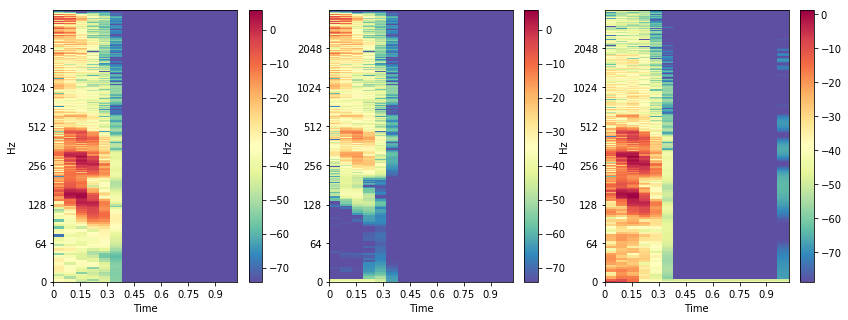

In [126]:
X=librosa.stft(xtest*max_test[p])
Xdec=librosa.stft(y*max_test[p])
Xfil=librosa.stft(xtest_fil*max_test_fil[p])
figure(figsize=(14, 5))
plt.subplot(1,3,1)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb.shape)
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
Xfildb = librosa.amplitude_to_db(abs(Xfil))
print(Xfildb.shape)
librosa.display.specshow(Xfildb, sr=sr, x_axis='time', y_axis='log',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
Xdecdb = librosa.amplitude_to_db(abs(Xdec))
print(Xdecdb.shape)
librosa.display.specshow(Xdecdb, sr=sr, x_axis='time', y_axis='log',cmap='Spectral_r')
colorbar()

In [127]:
error_spec=sklearn.metrics.mean_squared_error(Xdb,Xdecdb)
print(error_spec*1/Xdb.max())

21.86265624850943


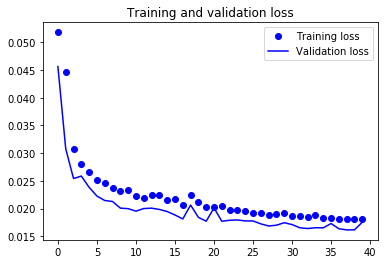

In [128]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

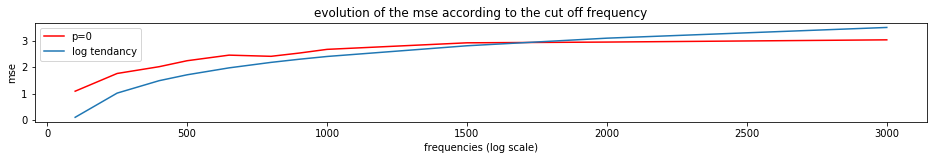

In [129]:
fc=[100,250,400,500,650,800,900,1000,1500,2000,3000]
mse0=[1.0935,1.7645,2.0208,2.2470,2.4586,2.4140,2.5361,2.6770,2.9249,2.9532,3.0375]

fig=plt.figure(figsize=(16, 4))
ax=fig.add_subplot(2,1,1)
plt.plot(fc,mse0,"r",label="p=0")
plt.plot(fc,np.log(fc)-4.5,label="log tendancy")
# ax.set_xscale('log')
plt.xlabel("frequencies (log scale)")
plt.ylabel('mse')
title("evolution of the mse according to the cut off frequency" )
plt.legend()
plt.show()

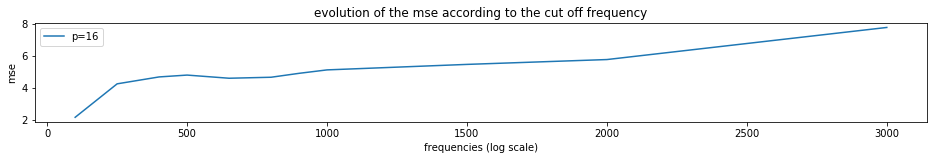

In [130]:
mse16=[2.1522,4.2412,4.6722,4.7873,4.5901,4.6523,4.8966,5.1111,5.4540,5.7564,7.7594]
fig=plt.figure(figsize=(16, 4))
ax=fig.add_subplot(2,1,1)

plt.plot(fc,mse16,label="p=16")
# ax.set_xscale('log')
plt.xlabel("frequencies (log scale)")
plt.ylabel('mse')
title("evolution of the mse according to the cut off frequency" )
plt.legend()
plt.show()

In [21]:
# mel spectro reconstruction
Xtest_mel,Phase_test=dir_to_log_mel(test_dir)
Xtrain_mel,Phase_train=dir_to_log_mel(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [22]:
Xtrain_fil_mel,Phase_train_fil=dir_to_log_mel(train_dir_filtré)
Xtest_fil_mel,Phase_test_fil=dir_to_log_mel(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [23]:
input_mel = Input(shape=(1024, 16,1))

conv1= Conv2D(32, (3, 3), activation='relu', padding='same')(input_mel)
max1= MaxPooling2D((2, 1), padding='same')(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(max1)
encoded = MaxPooling2D((2, 1), padding='same')(conv2)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)



decoded_mel = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
autoencoder_mel = Model(input_mel, decoded_mel)
autoencoder_mel.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder_mel.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1024, 16, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1024, 16, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 512, 16, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 16, 32)       9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 16, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 16, 32)       9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 16, 32)       9248      
__________

In [107]:
autoencoder_mel.fit(Xtrain_fil_mel,Xtrain_mel,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil_mel, Xtest_mel))

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 12s 7ms/step - loss: 0.0208 - val_loss: 0.0195
Epoch 2/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0207 - val_loss: 0.0199
Epoch 3/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0214 - val_loss: 0.0196
Epoch 4/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0201 - val_loss: 0.0194
Epoch 5/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0201 - val_loss: 0.0206
Epoch 6/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0199 - val_loss: 0.0195
Epoch 7/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0196 - val_loss: 0.0186
Epoch 8/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0191 - val_loss: 0.0182
Epoch 9/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0192 - val_loss: 0.0185
Epoch 10/20
1800/1800 [===

In [108]:
decoded_mel = autoencoder_mel.predict(Xtest_fil_mel)

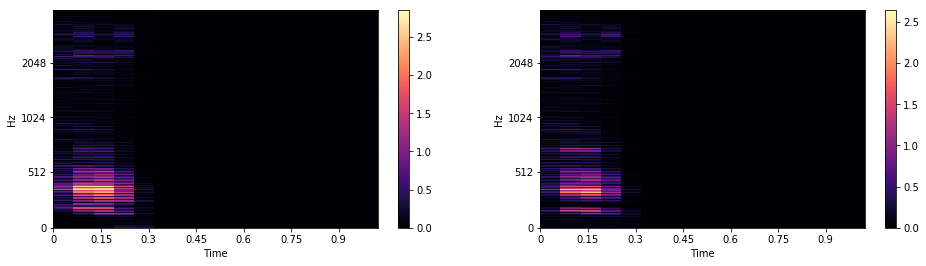

In [437]:
p=125
Spec_dec=np.reshape(decoded_mel[p],(decoded_mel.shape[1],decoded_mel.shape[2]))
Spec=np.reshape(Xtest_mel[p],(Xtest_mel.shape[1],Xtest_mel.shape[2]))
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
librosa.display.specshow(Spec, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()
plt.subplot(1,2,2)
librosa.display.specshow(Spec_dec, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()

In [438]:


y=np.reshape(decoded[p],(8000))
Y_stft=librosa.stft(y*max_test[p], n_fft=2048,window='hann') #we are going to keep the phase of this signal
Lin_dec=mel_to_linspec(decoded_mel,sr=8000,n_mels=1024,n_fft=2048)
print(Lin_dec.shape)
print(Y_stft.shape)
print(decoded_mel.dtype)
print(Lin_dec.dtype)

(200, 1024, 16)
(1025, 16)
float32
float64


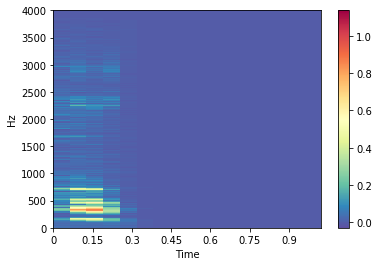

In [439]:
librosa.display.specshow(Lin_dec[p], sr=8000, x_axis='time', y_axis='hz',fmax=4000,cmap='Spectral_r')
colorbar()

In [440]:
MagY,PhaseY=librosa.magphase(Y_stft,2)
Audio=Lin_dec[p]*PhaseY[0:1024,:]
# Audio=Lin_dec[p]*Phase_test[p]
print(Audio.shape)


(1024, 16)


In [441]:
# we have to add a zero line at the index 1025 to Audio to avoid isftf interpolation
Audio=np.concatenate((Audio,np.zeros((1,16),dtype=complex)),axis=0)
print(Audio.shape)

(1025, 16)


In [463]:
xtest=np.reshape(Xtest[p],(8000))
soundfile.write(audio_path_record_in,xtest*max_test[p],sr)
ipd.Audio(audio_path_record_in)

In [464]:
xtest_fil=np.reshape(Xtest_fil[p],(8000))
soundfile.write(audio_path_record_in_fil,xtest_fil*max_test_fil[p],sr)
ipd.Audio(audio_path_record_in_fil)

In [465]:
y_fil=filtrage(bpost,apost,y)
soundfile.write(audio_path_record_out,y*max_test[p],sr)
ipd.Audio(audio_path_record_out)

In [466]:


audio_path_record_audio_mix=os.path.join(audio_path_record,"1_mix.wav")
audio_mix=librosa.istft(Audio)
soundfile.write(audio_path_record_audio_mix,audio_mix*20,sr)
ipd.Audio(audio_path_record_audio_mix)

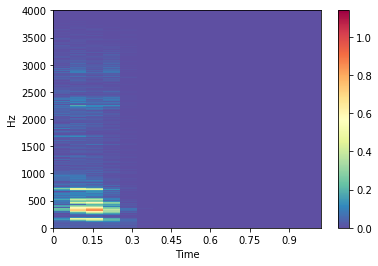

In [446]:
# Audiodb = librosa.amplitude_to_db(abs(Audio))

librosa.display.specshow(abs(Audio), sr=8000, x_axis='time', y_axis='hz',cmap='Spectral_r')
colorbar()

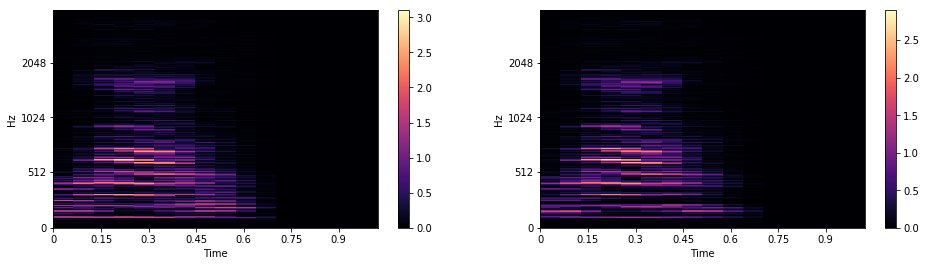

In [455]:
p2=180
Spec_dec2=np.reshape(decoded_mel[p2],(decoded_mel.shape[1],decoded_mel.shape[2]))
Spec2=np.reshape(Xtest_mel[p2],(Xtest_mel.shape[1],Xtest_mel.shape[2]))
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
librosa.display.specshow(Spec2, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()
plt.subplot(1,2,2)
librosa.display.specshow(Spec_dec2, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()


In [456]:
y2=np.reshape(decoded[p2],(8000))
Y_stft2=librosa.stft(y2*max_test[p2], n_fft=2048,window='hann') #we are going to keep the phase of this signal

print(Lin_dec.shape)
print(Y_stft2.shape)
print(decoded_mel.dtype)
print(Lin_dec.dtype)

(200, 1024, 16)
(1025, 16)
float32
float64


In [457]:
MagY2,PhaseY2=librosa.magphase(Y_stft2,2)
Audio2=Lin_dec[p2]*PhaseY2[0:1024,:]
# Audio=Lin_dec[p2]*Phase_test[p2]
print(Audio.shape)


(1025, 16)


In [462]:
xtest2=np.reshape(Xtest[p2],(8000))
soundfile.write(audio_path_record_in,xtest2*max_test[p2],sr)
ipd.Audio(audio_path_record_in)

In [467]:
xtest_fil2=np.reshape(Xtest_fil[p2],(8000))
soundfile.write(audio_path_record_in_fil,xtest_fil2*max_test_fil[p2],sr)
ipd.Audio(audio_path_record_in_fil)

In [460]:
audio_path_record_out2=os.path.join(audio_path_record,"2_reconstructed.wav")
soundfile.write(audio_path_record_out2,y2*max_test[p2],sr)
ipd.Audio(audio_path_record_out2)

In [458]:
audio_path_record_audio_mix2=os.path.join(audio_path_record,"2_mix.wav")
audio_mix2=librosa.istft(Audio2)
soundfile.write(audio_path_record_audio_mix2,audio_mix2*20,sr)
ipd.Audio(audio_path_record_audio_mix2)